# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
'''
simple progress widget
Copyright © 2017, Bostjan Mrak. Released under the MIT License.

install:
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension

usage:

#example 1

#init
w = progressWidget(label = "progress", max = 10)
#update
w.update(1)
#done
w.done()

#example 2

#init
w = progressWidget(label = "progress")
for i in w.enumerate(range(10)):

'''

class progressWidget:
    w = None
    wasInit = False
    jsDisabled = False
    try:
        from ipywidgets import FloatProgress
        from IPython.display import display
    except:
        jsDisabled = true
        print('Widgets disabled!')
    
    def __init__(self, label="", max=None):
        if (max == None):
            self.wasInit = False
            max = 0.0
        else:
            self.wasInit = True
        if (self.jsDisabled == False):
            try:
                self.w = self.FloatProgress(
                    value=0.0,
                    min=0.0,
                    max=max,
                    step=1.0,
                    description=label,
                    bar_style='info',
                    orientation='horizontal'
                )
                display(self.w)
            except:
                self.w = None
                print('Widgets disabled!')
        else:
            self.w = None
    def enumerate(self, list):
        if ((self.wasInit != True) and (self.w != None)):
            self.w.max = len(list)
            self.wasInit = True
        for idx, item in enumerate(list, 1):
            self.update(idx)
            yield item
        self.done()
    def update(self, value):
        if (self.w != None):
            self.w.value = value
            if (self.w.bar_style != 'info'):
                self.w.bar_style = 'info'
    def done(self):
        if (self.w != None):
            self.w.value = self.w.max
            self.w.bar_style = 'success'

In [2]:
'''
Helper functions
Copyright © 2017, Bostjan Mrak. Released under the MIT License.
'''

import cv2                
import matplotlib.pyplot as plt   
from IPython.display import display, Markdown
%matplotlib inline 

# performance metric calc
def performance_calc(TP, TN, FP, FN):
    accuracy = (TP+TN)/float(TP+TN+FP+FN)
    precision = TP/float(TP+FP)
    recall = TP/float(TP+FN)
    F1 = 2*((precision*recall)/(precision+recall))
    return accuracy, precision, recall, F1

# display images results
def display_images_results(items, title, dtype, limit=5):
    display(Markdown('___\n**' + title + '** (showing only first ' + str(limit) + ')'))
    if (len(items) > 0):
        for item in items[:limit]:
            imgcv = cv2.imread(item['filename'])
            if 'bounding_boxes' in item:
                if (dtype == 'face_cascade'):
                    for idx, (x,y,w,h) in enumerate(item['bounding_boxes']):
                        cv2.rectangle(imgcv,(int(x),int(y)),(int(x+w),int(y+h)),(255,0,0),2)
                elif (dtype == 'face_detector_MTCNN'):
                    for idx, (x,y,x2,y2,score) in enumerate(item['bounding_boxes']):
                        cv2.rectangle(imgcv,(int(x),int(y)),(int(x2),int(y2)),(255,0,0),2)
                        for fp in range(0,5):
                            cv2.circle(imgcv, (int(item['facialpoints'][fp][idx]), int(item['facialpoints'][fp+5][idx])), 3, (0, 255, 0), 1)
                        cv2.putText(imgcv, str(round(score*100, 2)), (int(x)+5,int(y)-5), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 0, 0))
            plt.figure()
            plt.imshow(cv2.cvtColor(imgcv, cv2.COLOR_BGR2RGB))    
        plt.show()
    else:
        display(Markdown('_no items_'))

In [3]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# setup tensorflow and random
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import random

# set random seeds

#random.seed(8675309)
#np.random.seed(42)
#tf.set_random_seed(1234)

# config tensorflow to use 0.7 of GPU memory
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [4]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

('Number of faces detected:', 1)


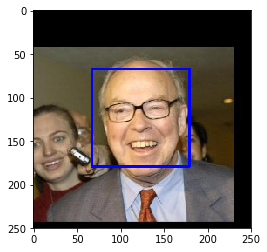

In [5]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0, faces

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


From 100 images in human_files there are 100 (100.00%) faces
From 100 images in dog_files there are 11 (11.00%) faces

Accuracy: 0.945
Precision: 0.9009
Recall: 1.0
F1 score: 0.9479


___
**FALSE NEGATIVE** (showing only first 5)

_no items_

___
**FALSE POSITIVE** (showing only first 5)

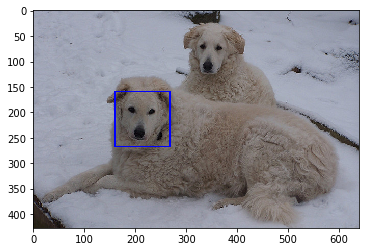

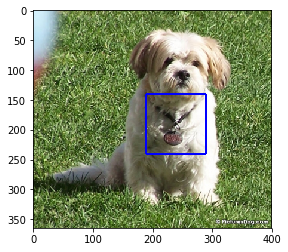

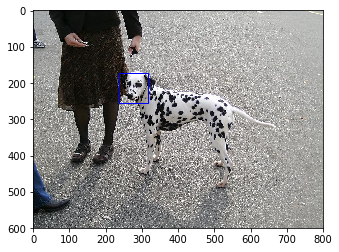

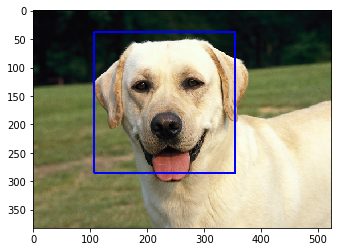

In [7]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
w = progressWidget(label = "humans")
w2 = progressWidget(label = "dogs")

TP = 0 # true positive = human face detected in human files dataset
TN = 0 # true negative = human face not detected in dog files dataset
FP = 0 # false positive = human face detected in dog files dataset
FN = 0 # false negative = human face not detected in human files dataset

FN_list = list() # list of false negatives
FP_list = list() # list of false positives

# iterate human files dataset
for imgfn in w.enumerate(human_files_short):
    facedetected, bounding_boxes = face_detector(imgfn)
    if facedetected:
        TP += 1 # face detected
    else:
        FN += 1 # face not detected
        FN_list.append({'filename': imgfn})
        
# iterate dog files dataset
for imgfn in w2.enumerate(dog_files_short):
    facedetected, bounding_boxes = face_detector(imgfn)
    if facedetected:
        FP += 1 # face detected
        FP_list.append({'filename': imgfn, 'bounding_boxes': bounding_boxes})
    else:
        TN += 1 # face not detected
      
# performance calc
accuracy, precision, recall, F1 = performance_calc(TP, TN, FP, FN)
        
# print results
print("From {} images in human_files there are {} ({:.2%}) faces".format(len(human_files_short), TP, TP/float(len(human_files_short))))
print("From {} images in dog_files there are {} ({:.2%}) faces".format(len(dog_files_short), FP, FP/float(len(dog_files_short))))
print("\nAccuracy: {:.4}\nPrecision: {:.4}\nRecall: {:.4}\nF1 score: {:.4}".format(accuracy, precision, recall, F1))

# display false negatives
display_images_results(FN_list, 'FALSE NEGATIVE', 'face_cascade', 5)
# display false positives
display_images_results(FP_list, 'FALSE POSITIVE', 'face_cascade', 5)


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

Front facing pose of the user is essential for our application as we apply mask to face and try to predict matching dog breed based on face. I've choosen MTCNN Face detector that works well to some angle of face orientation, but it is still just face detection. It will not work as human detector if there are no visible face.

For human/person detection we could use object detection CNN, probably Faster RCNN, R-FCN (region based fully convolutional net) or SSD (Single shot detector), all algorithms are available in tensorflow. We will need to retrain network of our choice on dataset (can be "Caltech Pedestrian Dataset" - http://www.vision.caltech.edu/Image_Datasets/CaltechPedestrians/) or find a pretrained model. Another option is to use OpenCV implementation of HOG + SVM pedestrian detector, that works well and it's easier to implement. As this detection is common in security and autonomous vehicles, I'm sure we could find a good performing model for task of Human/Person detection.


In [8]:
'''
MTCNN Face detector class wrapper for easier usage I wrote for this project.

Multi-task Cascaded Convolutional Networks for Face Detection and Alignment.
https://kpzhang93.github.io/MTCNN_face_detection_alignment/index.html

@ARTICLE{7553523, 
author={K. Zhang and Z. Zhang and Z. Li and Y. Qiao}, 
journal={IEEE Signal Processing Letters}, 
title={Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks}, 
year={2016}, 
volume={23}, 
number={10}, 
pages={1499-1503}, 
keywords={Benchmark testing;Computer architecture;Convolution;Detectors;Face;Face detection;Training;Cascaded convolutional neural network (CNN);face alignment;face detection}, 
doi={10.1109/LSP.2016.2603342}, 
ISSN={1070-9908}, 
month={Oct},}

Using tensorflow implementation from FaceNet.
https://github.com/davidsandberg/facenet/tree/master/src/align

'''

import tensorflow as tf
import numpy as np
from scipy import misc
import detect_face.detect_face as facedetect_mtcnn

class face_detector_MTCNN:
    # Set hyperparameters for mtcnn face detection, tuned for best performance on our dataset.
    # recomended parameters for other usages are:
    # minsize = 20
    # threshold = [ 0.6, 0.7, 0.7 ] 
    # factor = 0.709
    minsize = 125 # minimum size of face
    threshold = [ 0.75, 0.75, 0.75 ]  # three steps's threshold
    factor = 0.95 # scale factor
    sess = None
    pnet = None
    rnet = None
    onet = None

    def __init__(self):
        self.init()
                
    def __del__(self):
        self.cleanup()
        
    # Init tensorflow and load network.
    # Weights are in folder /detect_face/  det1.npy, det2.npy, det3.npy
    def init(self):
        with tf.Graph().as_default():
            # limit tensorflow gpu usage
            gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
            # create tensorflow session
            self.sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
            with self.sess.as_default():
                # init network and load weights
                self.pnet, self.rnet, self.onet = facedetect_mtcnn.create_mtcnn(self.sess, None)
                
    # Cleanup
    def cleanup(self):
        try:
            self.sess.close()
        except:
            print "Unexpected error:", sys.exc_info()[0]
        finally:
            self.sess = None
            self.pnet = None
            self.rnet = None
            self.onet = None
    
    # Face detector function
    # returns: face_detected [bool], bounding_boxes [array], facialpoints [array]
    def detect(self, img_path):
        # check if is init
        if (self.sess is None):
            self.init()
        # read image
        img = misc.imread(img_path)
        # run detection
        bounding_boxes, facialpoints = facedetect_mtcnn.detect_face(img, self.minsize, self.pnet, self.rnet, self.onet, self.threshold, self.factor)
        nrof_faces = bounding_boxes.shape[0]
        return nrof_faces > 0, bounding_boxes, facialpoints


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


From 500 images in human_files there are 500 (100.00%) faces
From 500 images in dog_files there are 35 (7.00%) faces

Accuracy: 0.965
Precision: 0.9346
Recall: 1.0
F1 score: 0.9662


___
**FALSE NEGATIVE** (showing only first 5)

_no items_

___
**FALSE POSITIVE** (showing only first 5)

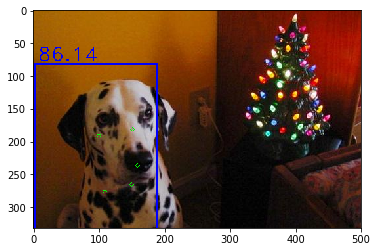

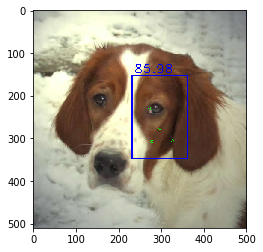

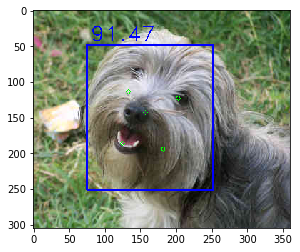

In [9]:
'''
Run face detection on first 500 human files and first 500 dog files.
'''

human_files_short_500 = human_files[:500] # increased size to 500
dog_files_short_500 = train_files[:500] # increased size to 500

w = progressWidget(label = "humans")
w2 = progressWidget(label = "dogs")

TP = 0 # true positive = human face detected in human files dataset
TN = 0 # true negative = human face not detected in dog files dataset
FP = 0 # false positive = human face detected in dog files dataset
FN = 0 # false negative = human face not detected in human files dataset

FN_list = list() # list of false negatives
FP_list = list() # list of false positives

# init face detector
face_detector_MTCNN_obj = face_detector_MTCNN()

# iterate human files dataset
for imgfn in w.enumerate(human_files_short_500):
    facedetected, bounding_boxes, facialpoints = face_detector_MTCNN_obj.detect(imgfn)
    if facedetected:
        TP += 1 # face detected
    else:
        FN += 1 # face not detected
        FN_list.append({'filename': imgfn})
        
# iterate dog files dataset
for imgfn in w2.enumerate(dog_files_short_500):
    facedetected, bounding_boxes, facialpoints = face_detector_MTCNN_obj.detect(imgfn)
    if facedetected:
        FP += 1 # face detected
        FP_list.append({'filename': imgfn, 'bounding_boxes': bounding_boxes, 'facialpoints': facialpoints})
    else:
        TN += 1 # face not detected
        
# clean up to free tensorflow GPU
del face_detector_MTCNN_obj
      
# performance calc
accuracy, precision, recall, F1 = performance_calc(TP, TN, FP, FN)
        
# print results
print("From {} images in human_files there are {} ({:.2%}) faces".format(len(human_files_short_500), TP, TP/float(len(human_files_short_500))))
print("From {} images in dog_files there are {} ({:.2%}) faces".format(len(dog_files_short_500), FP, FP/float(len(dog_files_short_500))))
print("\nAccuracy: {:.4}\nPrecision: {:.4}\nRecall: {:.4}\nF1 score: {:.4}".format(accuracy, precision, recall, F1))

# display false negatives
display_images_results(FN_list, 'FALSE NEGATIVE', 'face_detector_MTCNN', 5)
# display false positives
display_images_results(FP_list, 'FALSE POSITIVE', 'face_detector_MTCNN', 5)
    

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [10]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [11]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [12]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

import cv2                
import matplotlib.pyplot as plt   
from IPython.display import display, Markdown
%matplotlib inline 

w = progressWidget(label = "humans")
w2 = progressWidget(label = "dogs")

TP = 0 # true positive = dog detected in dog files dataset
TN = 0 # true negative = dog not detected in human files dataset
FP = 0 # false positive = dog detected in human files dataset
FN = 0 # false negative = dog not detected in dog files dataset

FN_list = list() # list of false negatives
FP_list = list() # list of false positives

# iterate human files dataset
for imgfn in w.enumerate(human_files_short):
    dogdetected = dog_detector(imgfn)
    if dogdetected:
        FP += 1 # dog detected
        FP_list.append({'filename': imgfn})
    else:
        TN += 1 # dog not detected
        
# iterate dog files dataset
for imgfn in w2.enumerate(dog_files_short):
    dogdetected = dog_detector(imgfn)
    if dogdetected:
        TP += 1 # dog detected
    else:
        FN += 1 # dog not detected
        FN_list.append({'filename': imgfn})
      
# performance calc
accuracy, precision, recall, F1 = performance_calc(TP, TN, FP, FN)
        
# print results
print("From {} images in human_files there are {} ({:.2%}) dogs".format(len(human_files_short), FP, FP/float(len(human_files_short))))
print("From {} images in dog_files there are {} ({:.2%}) dogs".format(len(dog_files_short), TP, TP/float(len(dog_files_short))))
print("\nAccuracy: {:.4}\nPrecision: {:.4}\nRecall: {:.4}\nF1 score: {:.4}".format(accuracy, precision, recall, F1))

# display false negatives
display_images_results(FN_list, 'FALSE NEGATIVE', 'ResNet50_predict_labels', 5)
# display false positives
display_images_results(FP_list, 'FALSE POSITIVE', 'ResNet50_predict_labels', 5)


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


From 100 images in human_files there are 1 (1.00%) dogs
From 100 images in dog_files there are 100 (100.00%) dogs

Accuracy: 0.995
Precision: 0.9901
Recall: 1.0
F1 score: 0.995


___
**FALSE NEGATIVE** (showing only first 5)

_no items_

___
**FALSE POSITIVE** (showing only first 5)

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [15]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:04<00:00, 183.26it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

With CNN there are no rules what arhitecture would work best, there are many arhitectures and all will perform different on different classification problems. Best way to design CNN is to start small with one hidden layer + output layer and test then gradually make net wider (add more neurons/filter) or larger (add more layers). Keep in mind that dropout has to be disabled while testing architecture. In this case I've followed suggested architecture and gradually extend that. I've actually spend couple of hours to try out different architectures, with dynamic structure and grid search.

Final architecture has 4 cnn blocks and 2 fully connected layers with dropout. Convolutional filter with kernel size of 3, that was chosen based on size of input images. Number of filters are increasing *2 on each block. It's good to choose number of filters with prime of 2, this is not necessary but we have binary machines and this "looks" more logical. ReLu activations as they are faster to calculate and are close to sigmoid. After conv2D we have max pooling size 2 with stride of 2. After max pooling I've added batch normalization for normalization and regularization. Finally fully connected layers that maps 1d features to softmax regression output to number of dog breeds of our detector.

In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.

from keras.layers.normalization import BatchNormalization

# CNN layer 1
# depth 16
# Kernel size 3 would work fine with our dataset - image size. If we had smaller input images we would use kernel size 2.
# Max pooling of 2 with stride of 2
# BatchNormalization as normalization and regulization method
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

# CNN layer 2
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

# CNN layer 3
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

# CNN layer 4
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

# Showed good results with low epoch
model.add(GlobalAveragePooling2D())

# Fully connected dense layer
model.add(Dense(512, activation='relu'))

# Dropout overfit regulation
model.add(Dropout(0.2))

# Softmax output layer
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       73856     
__________

### Compile the Model

In [17]:
from keras.optimizers import SGD
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [18]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 20

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)


Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 26s - loss: 4.8034 - acc: 0.0259 - val_loss: 8.3792 - val_acc: 0.0084
Epoch 2/20
6680/6680 [==============================] - 25s - loss: 4.3426 - acc: 0.0558 - val_loss: 5.1039 - val_acc: 0.0323
Epoch 3/20
6680/6680 [==============================] - 25s - loss: 3.9910 - acc: 0.0898 - val_loss: 4.1767 - val_acc: 0.0838
Epoch 4/20
6680/6680 [==============================] - 25s - loss: 3.6836 - acc: 0.1271 - val_loss: 4.2332 - val_acc: 0.0886
Epoch 5/20
6680/6680 [==============================] - 25s - loss: 3.4218 - acc: 0.1722 - val_loss: 3.8995 - val_acc: 0.0958
Epoch 6/20
6680/6680 [==============================] - 25s - loss: 3.1708 - acc: 0.2066 - val_loss: 3.8339 - val_acc: 0.1425
Epoch 7/20
6680/6680 [==============================] - 25s - loss: 2.9461 - acc: 0.2497 - val_loss: 4.4222 - val_acc: 0.1509
Epoch 8/20
6680/6680 [==============================] - 25s - loss: 2.7

### Load the Model with the Best Validation Loss

In [19]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [20]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 31.0000%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [21]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [22]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [23]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [24]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.0063 - acc: 0.1347 - val_loss: 10.6188 - val_acc: 0.2156
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 9.6882 - acc: 0.2907 - val_loss: 9.5119 - val_acc: 0.2946
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 8.9348 - acc: 0.3746 - val_loss: 9.2464 - val_acc: 0.3377
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 8.6777 - acc: 0.4090 - val_loss: 9.0061 - val_acc: 0.3581
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 8.3657 - acc: 0.4361 - val_loss: 8.7682 - val_acc: 0.3725
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 8.1154 - acc: 0.4555 - val_loss: 8.4846 - val_acc: 0.3820
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 7.9259 - acc: 0.4753 - val_loss: 8.4711 - val_acc: 0.3928
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 7.8210 - 

### Load the Model with the Best Validation Loss

In [25]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [26]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 44.0000%


### Predict Dog Breed with the Model

In [27]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [28]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
'''
# We could use this implementation, but I would extract bottleneck features
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']
'''

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
import os.path

def create_bottleneck_features(saveInZip=False):
    print('Creating bottleneck features...')
    
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = Xception(include_top=False, weights='imagenet')
    # TRAIN DATA BLOCK
    # match image size to default input size for Xception model = 299x299. Would help get better results
    # (number of samples / batch_size) modulus should be 0
    generator_train = datagen.flow_from_directory(
        'dogImages/train',
        target_size=(299, 299),
        batch_size=40,
        class_mode=None,
        shuffle=False)
    # get number of samples
    nb_train_samples = len(generator_train.filenames)
    # get features
    bottleneck_features_train = model.predict_generator(generator_train, nb_train_samples // 40, verbose=1)
    bottleneck_features_classes_train = generator_train.classes
    
    # VALIDATION DATA BLOCK
    generator_valid = datagen.flow_from_directory(
        'dogImages/valid',
        target_size=(299, 299),
        batch_size=5,
        class_mode=None,
        shuffle=False)
    nb_validation_samples = len(generator_valid.filenames)
    bottleneck_features_validation = model.predict_generator(generator_valid, nb_validation_samples // 5, verbose=1)
    bottleneck_features_classes_validation = generator_valid.classes
    
    # TEST DATA BLOCK
    generator_test = datagen.flow_from_directory(
        'dogImages/test',
        target_size=(299, 299),
        batch_size=4,
        class_mode=None,
        shuffle=False)
    nb_test_samples = len(generator_test.filenames)
    bottleneck_features_test = model.predict_generator(generator_test, nb_test_samples // 4, verbose=1)
    bottleneck_features_classes_test = generator_test.classes
    
    print('Saving bottleneck features...')
    
    if (saveInZip):
        np.savez('bottleneck_features/DogXceptionData_v2.npz', 
                 train=bottleneck_features_train, 
                 train_labels=bottleneck_features_classes_train,
                 valid=bottleneck_features_validation,
                 valid_labels=bottleneck_features_classes_validation,
                 test=bottleneck_features_test,
                 test_labels=bottleneck_features_classes_test
                )
    else:
        np.save(open('bottleneck_features/DogXceptionData_train_v2.npy', 'w'), bottleneck_features_train)
        np.save(open('bottleneck_features/DogXceptionData_train_labels_v2.npy', 'w'), bottleneck_features_classes_train)
        np.save(open('bottleneck_features/DogXceptionData_valid_v2.npy', 'w'), bottleneck_features_validation)
        np.save(open('bottleneck_features/DogXceptionData_valid_labels_v2.npy', 'w'), bottleneck_features_classes_validation)
        np.save(open('bottleneck_features/DogXceptionData_test_v2.npy', 'w'), bottleneck_features_test)
        np.save(open('bottleneck_features/DogXceptionData_test_labels_v2.npy', 'w'), bottleneck_features_classes_test)        
        
    print('Bottleneck features created and saved')

# My PC crashes (RAM or disc access issue) using zip file, so I will choose separated files
useZip = False
    
print('Loading bottleneck features...')

if (useZip):
    if not os.path.exists('bottleneck_features/DogXceptionData_v2.npz'):
        create_bottleneck_features(saveInZip=True)

    bottleneck_features = np.load('bottleneck_features/DogXceptionData_v2.npz')
    train_Xception = bottleneck_features['train']
    valid_Xception = bottleneck_features['valid']
    test_Xception = bottleneck_features['test']
    train_labels_Xception = np_utils.to_categorical(bottleneck_features['train_labels'], num_classes=133)
    valid_labels_Xception = np_utils.to_categorical(bottleneck_features['valid_labels'], num_classes=133)
    test_labels_Xception = np_utils.to_categorical(bottleneck_features['test_labels'], num_classes=133)
    
else:
    if not (os.path.exists('bottleneck_features/DogXceptionData_train_v2.npy') and
        os.path.exists('bottleneck_features/DogXceptionData_train_labels_v2.npy') and 
        os.path.exists('bottleneck_features/DogXceptionData_valid_v2.npy') and 
        os.path.exists('bottleneck_features/DogXceptionData_valid_labels_v2.npy') and 
        os.path.exists('bottleneck_features/DogXceptionData_test_v2.npy') and 
        os.path.exists('bottleneck_features/DogXceptionData_test_labels_v2.npy')):
        create_bottleneck_features(saveInZip=False)

    train_Xception = np.load(open('bottleneck_features/DogXceptionData_train_v2.npy'))
    valid_Xception = np.load(open('bottleneck_features/DogXceptionData_valid_v2.npy'))
    test_Xception = np.load(open('bottleneck_features/DogXceptionData_test_v2.npy'))
    train_labels_Xception = np_utils.to_categorical(np.load(open('bottleneck_features/DogXceptionData_train_labels_v2.npy')), num_classes=133)
    valid_labels_Xception = np_utils.to_categorical(np.load(open('bottleneck_features/DogXceptionData_valid_labels_v2.npy')), num_classes=133)
    test_labels_Xception = np_utils.to_categorical(np.load(open('bottleneck_features/DogXceptionData_test_labels_v2.npy')), num_classes=133)

print('Bottleneck features loaded')

Loading bottleneck features...
Bottleneck features loaded


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [29]:
### TODO: Define your architecture.
Xception_model = Sequential()

# pooling
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
# dense layer 1
Xception_model.add(Dense(1024, activation='relu'))  
# dropout regulation to prevent overfit
Xception_model.add(Dropout(0.2))  
# dense layer 2
Xception_model.add(Dense(256, activation='relu')) 
# dropout regulation to prevent overfit
Xception_model.add(Dropout(0.3)) 
# softmax to 133 classes
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               34181     
Total params: 2,394,757
Trainable params: 2,394,757
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [30]:
### TODO: Compile the model.
from keras.optimizers import RMSprop
# we will start with learning rate = 1e-4
Xception_model.compile(optimizer=RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0), loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [31]:
### TODO: Train the model.

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# checkpointer to save only best model > full model with arhitecture and weights will be saved
checkpointer = ModelCheckpoint(filepath='saved_models/best.Xception.h5', verbose=1, save_best_only=True)
# reduce learning rate by 0.2 if loss doesnt decrease for 5 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
# model training
Xception_model.fit(train_Xception, train_labels_Xception,
              epochs=50,
              batch_size=40,
              validation_data=(valid_Xception, valid_labels_Xception), 
              callbacks=[checkpointer, reduce_lr],
              verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
Epoch 00000: val_loss improved from inf to 2.27088, saving model to saved_models/best.Xception.h5
10s - loss: 3.7771 - acc: 0.3699 - val_loss: 2.2709 - val_acc: 0.7030
Epoch 2/50
Epoch 00001: val_loss improved from 2.27088 to 0.90756, saving model to saved_models/best.Xception.h5
4s - loss: 1.7231 - acc: 0.6852 - val_loss: 0.9076 - val_acc: 0.8144
Epoch 3/50
Epoch 00002: val_loss improved from 0.90756 to 0.55665, saving model to saved_models/best.Xception.h5
3s - loss: 0.9268 - acc: 0.7771 - val_loss: 0.5567 - val_acc: 0.8695
Epoch 4/50
Epoch 00003: val_loss improved from 0.55665 to 0.43637, saving model to saved_models/best.Xception.h5
4s - loss: 0.6772 - acc: 0.8160 - val_loss: 0.4364 - val_acc: 0.8886
Epoch 5/50
Epoch 00004: val_loss improved from 0.43637 to 0.40212, saving model to saved_models/best.Xception.h5
3s - loss: 0.5419 - acc: 0.8522 - val_loss: 0.4021 - val_acc: 0.8778
Epoch 6/50
Epoch 00005: val_loss improved from

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [32]:
### TODO: Load the model weights with the best validation loss.
Xception_model.load_weights('saved_models/best.Xception.h5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [33]:
### TODO: Calculate classification accuracy on the test dataset.
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_labels_Xception, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 90.0000%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [34]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing import image

xceptionpreloaded = Xception(weights='imagenet', include_top=False)

def extract_Xception_fc(tensor):
    return xceptionpreloaded.predict(preprocess_input(tensor))

def Xception_predict_breed(img_path):
    img_ = np.expand_dims(image.img_to_array(image.load_img(img_path, target_size=(299, 299))), axis=0)
    bottleneck_feature = extract_Xception_fc(img_)
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    # get top 3 results
    topResults = []
    topResults.append([])
    topResults.append([])
    for _ in np.argsort(-predicted_vector[0])[:3]:
        topResults[0].append(predicted_vector[0][_])
        topResults[1].append(dog_names[_])
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)], topResults

print(Xception_predict_breed('dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg'))

('Affenpinscher', [[0.99890888, 0.0010808646, 1.5913133e-06], ['Affenpinscher', 'Brussels_griffon', 'Lhasa_apso']])


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [35]:
'''
Dog classifier
'''

from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Sequential
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
import cv2
import math

class dog_classifier:

    modelpreloaded = None
    model = None
    face_cascade = None
    # labels
    dog_names = ['Affenpinscher', 'Afghan_hound', 'Airedale_terrier', 'Akita', 'Alaskan_malamute', 'American_eskimo_dog', 'American_foxhound', 'American_staffordshire_terrier', 'American_water_spaniel', 'Anatolian_shepherd_dog', 'Australian_cattle_dog', 'Australian_shepherd', 'Australian_terrier', 'Basenji', 'Basset_hound', 'Beagle', 'Bearded_collie', 'Beauceron', 'Bedlington_terrier', 'Belgian_malinois', 'Belgian_sheepdog', 'Belgian_tervuren', 'Bernese_mountain_dog', 'Bichon_frise', 'Black_and_tan_coonhound', 'Black_russian_terrier', 'Bloodhound', 'Bluetick_coonhound', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_terrier', 'Bouvier_des_flandres', 'Boxer', 'Boykin_spaniel', 'Briard', 'Brittany', 'Brussels_griffon', 'Bull_terrier', 'Bulldog', 'Bullmastiff', 'Cairn_terrier', 'Canaan_dog', 'Cane_corso', 'Cardigan_welsh_corgi', 'Cavalier_king_charles_spaniel', 'Chesapeake_bay_retriever', 'Chihuahua', 'Chinese_crested', 'Chinese_shar-pei', 'Chow_chow', 'Clumber_spaniel', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dachshund', 'Dalmatian', 'Dandie_dinmont_terrier', 'Doberman_pinscher', 'Dogue_de_bordeaux', 'English_cocker_spaniel', 'English_setter', 'English_springer_spaniel', 'English_toy_spaniel', 'Entlebucher_mountain_dog', 'Field_spaniel', 'Finnish_spitz', 'Flat-coated_retriever', 'French_bulldog', 'German_pinscher', 'German_shepherd_dog', 'German_shorthaired_pointer', 'German_wirehaired_pointer', 'Giant_schnauzer', 'Glen_of_imaal_terrier', 'Golden_retriever', 'Gordon_setter', 'Great_dane', 'Great_pyrenees', 'Greater_swiss_mountain_dog', 'Greyhound', 'Havanese', 'Ibizan_hound', 'Icelandic_sheepdog', 'Irish_red_and_white_setter', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_chin', 'Keeshond', 'Kerry_blue_terrier', 'Komondor', 'Kuvasz', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberger', 'Lhasa_apso', 'Lowchen', 'Maltese', 'Manchester_terrier', 'Mastiff', 'Miniature_schnauzer', 'Neapolitan_mastiff', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_buhund', 'Norwegian_elkhound', 'Norwegian_lundehund', 'Norwich_terrier', 'Nova_scotia_duck_tolling_retriever', 'Old_english_sheepdog', 'Otterhound', 'Papillon', 'Parson_russell_terrier', 'Pekingese', 'Pembroke_welsh_corgi', 'Petit_basset_griffon_vendeen', 'Pharaoh_hound', 'Plott', 'Pointer', 'Pomeranian', 'Poodle', 'Portuguese_water_dog', 'Saint_bernard', 'Silky_terrier', 'Smooth_fox_terrier', 'Tibetan_mastiff', 'Welsh_springer_spaniel', 'Wirehaired_pointing_griffon', 'Xoloitzcuintli', 'Yorkshire_terrier']

    def __init__(self, weightsfn = 'saved_models/best.Xception.h5', facecascadefn = 'haarcascades/haarcascade_frontalface_alt.xml'):
        # load base xception model
        self.modelpreloaded = Xception(weights='imagenet', include_top=False)
        # load model
        self.model = load_model('bottleneck_fc_model.h5')
        # load face cascade
        self.face_cascade = cv2.CascadeClassifier(facecascadefn)
                    
    # unescape names > it would be more efficient to unescape dog_names list
    def nameUnescape(self, instr):
        return instr.replace("_", " ")
    
    # extract bottleneck features for tensor
    def extractBNF(self, tensor):
        return self.modelpreloaded.predict(preprocess_input(tensor))
    
    # conevert file to tensor
    def path_to_tensor(self, img_path):
        return np.expand_dims(image.img_to_array(image.load_img(img_path, target_size=(224, 224))), axis=0)
    
    def predict_breed(self, img_path):
        img_ = np.expand_dims(image.img_to_array(image.load_img(img_path, target_size=(299, 299))), axis=0)
        bottleneck_feature = self.extractBNF(img_)
        # obtain predicted vector
        predicted_vector = self.model.predict(bottleneck_feature)
        # get top 3 results
        topResults = []
        topResults.append([])
        topResults.append([])
        for _ in np.argsort(-predicted_vector[0])[:3]:
            topResults[0].append(predicted_vector[0][_])
            topResults[1].append(self.dog_names[_])
        # return dog breed that is predicted by the model
        return topResults
    
    def face_detector(self, img_path):
        faces = self.face_cascade.detectMultiScale(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY))
        return len(faces) > 0

    def classify(self, imgfn):
        topDogBreedResults = self.predict_breed(imgfn)
        if (np.sum(topDogBreedResults[0]) > 0.6):
            # check if mutt
            if (math.sqrt((topDogBreedResults[0][0]-topDogBreedResults[0][1])**2) < 0.5):
                return {'imgfn': imgfn, 'type': 'mutt', 'breed': self.nameUnescape(topDogBreedResults[1][0]) + " / " + self.nameUnescape(topDogBreedResults[1][1]), 'top3': topDogBreedResults}
            else:
                return {'imgfn': imgfn, 'type': 'dog', 'breed': self.nameUnescape(topDogBreedResults[1][0]), 'top3': topDogBreedResults}
        else:
            # is it person
            facedetected = self.face_detector(imgfn)
            if (facedetected):
                return {'imgfn': imgfn, 'type': 'person', 'topDogBreedMatch': self.nameUnescape(topDogBreedResults[1][0]), 'topDogBreedMatchScore': topDogBreedResults[0][0], 'top3': topDogBreedResults}
            else:
                return {'imgfn': imgfn, 'type': 'unknown', 'top3': topDogBreedResults}


In [36]:
'''
Dog app
'''

import cv2                
import matplotlib.pyplot as plt
%matplotlib inline 

def loadMaskObj():
    maskimg = cv2.imread('snapchatfilterdogmask.png', cv2.IMREAD_UNCHANGED)
    mask_obj = {'earL': {'img': maskimg[55:195, 0:160], 'anchor': [95, 80], 'alpha': [], 'alpha_inv': []}, 
                'earR': {'img': maskimg[55:195, 257:417], 'anchor': [65, 80], 'alpha': [], 'alpha_inv': []}, 
                'nose': {'img': maskimg[300:388, 150:300], 'anchor': [70, 40], 'alpha': [], 'alpha_inv': []}}
    # get alpha channel normalized, inv alpha channel normalized
    for mask_obj_key in mask_obj.iterkeys():
        mask_obj[mask_obj_key]['alpha'] = mask_obj[mask_obj_key]['img'][:,:,3] / 255.0
        mask_obj[mask_obj_key]['alpha_inv'] = 1.0 - mask_obj[mask_obj_key]['alpha']
    return mask_obj

def resizeMask(mask_obj, facesize):
    mask_obj_ = {'earL': {'img': [], 'anchor': [], 'alpha': [], 'alpha_inv': []}, 
                'earR': {'img': [], 'anchor': [], 'alpha': [], 'alpha_inv': []}, 
                'nose': {'img': [], 'anchor': [], 'alpha': [], 'alpha_inv': []}}
    # calculate scale from facesize
    scale = (0.35 * facesize) / 96.0
    # resize img, recalc ancohor, recreate alpha masks
    for mask_obj_key in mask_obj.iterkeys():
        mask_obj_[mask_obj_key]['img'] = cv2.resize(mask_obj[mask_obj_key]['img'], None, fx = scale, fy = scale, interpolation = cv2.INTER_AREA)
        mask_obj_[mask_obj_key]['anchor'] = [int(mask_obj[mask_obj_key]['anchor'][0] * scale), int(mask_obj[mask_obj_key]['anchor'][1] * scale)]
        mask_obj_[mask_obj_key]['alpha'] = mask_obj_[mask_obj_key]['img'][:,:,3] / 255.0
        mask_obj_[mask_obj_key]['alpha_inv'] = 1.0 - mask_obj_[mask_obj_key]['alpha']
    
    return mask_obj_

def drawOverlayPic(img, obj, x, y):
    x = max(0, x - obj['anchor'][0])
    y = max(0, y - obj['anchor'][1])
    
    y1, y2 = max(0, y), min(img.shape[0], y + obj['img'].shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + obj['img'].shape[1])
    y1o, y2o = max(0, -y), min(obj['img'].shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(obj['img'].shape[1], img.shape[1] - x)
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return img
    
    for c in range(3):
        img[y1:y2, x1:x2, c] = (obj['alpha'] * obj['img'][y1o:y2o, x1o:x2o, c] +
                                obj['alpha_inv'] * img[y1:y2, x1:x2, c])
    return img

def outputResult(result, addFaceMask=False, printTop3Predictions=False):
    # image
    imgcv = cv2.imread(result['imgfn'])
    if ((addFaceMask) and (result['type'] == 'person')):
        # detect face features
        facedetected, bounding_boxes, facialpoints = face_detector_MTCNN_obj.detect(result['imgfn'])
        if (facedetected):
            for idx, (x,y,x2,y2,score) in enumerate(bounding_boxes):
                # only one face
                if (idx == 0):
                    # resize mask to face size
                    mask_obj_resized = resizeMask(mask_obj, x2-x)
                    # draw right ear
                    imgcv = drawOverlayPic(imgcv, mask_obj_resized['earL'], int(x), int(y))
                    # draw left ear
                    imgcv = drawOverlayPic(imgcv, mask_obj_resized['earR'], int(x2), int(y))
                    # draw nose
                    imgcv = drawOverlayPic(imgcv, mask_obj_resized['nose'], int(facialpoints[2][idx]), int(facialpoints[2+5][idx]))
    # output image in notebook
    plt.figure()
    plt.imshow(cv2.cvtColor(imgcv, cv2.COLOR_BGR2RGB))    
    plt.show()
    # for debuging output top 3 predictions
    if (printTop3Predictions == True):
        print(result['top3'])
    # generate image caption
    if (result['type'] == 'person'):
        # if top dog match at least 15% > should be higher for better match but then algorithm would rarely output dog breed
        if (result['topDogBreedMatchScore'] > 0.15):
            print("Probabily you own a \"" + result['topDogBreedMatch'] + "\" or you should.")
        else:
            print("This looks like a human")
    elif (result['type'] == 'mutt'):
        # if mutt. top two breeds have close scores
        print("Cute mutt. Looks like a crossbreed of " + result['breed'] + "?")
    elif (result['type'] == 'dog'):
        # probably a purebreed.
        print("Cute Dog. I guess it's a " + result['breed'] + "?")
    else:
        # no dog or person detected
        print("Is it UFO, Alien or just Unknown object...")

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

Output is better than expected, it actually performs very well, but surely it can get even better. I've done many things to get to 90% accuracy on test set, including data augmentation and tweaking hyper-parameters of optimizer. I've also tried fine tuning but it was too time consuming and didn't actually lower the loss score by significant amount. I've also tried inception and resnet, they were both performing worse (around 88% accuracy) at 50 epochs of training.

My suggestions for improvements are:
1. Increase dataset - find more images of dogs.
2. More aggressive data augmentation.
3. Increase epochs of learning.
4. Fine Tuning. Low learning rate, freeze layers before 125.
5. Change architecture of our model - try without dropout, change number of filters, etc.

We could get better result if we had time - it's always about the time :)

### Instructions

__Requirements:__  

{projectfolder}/detect_face/*  
> included in zipped source
    
{projectfolder}/snapchatfilterdogmask.png  
> included in zipped source  

{projectfolder}/saved_models/best.Xception.h5
> included in zipped source  

__Requirements from git source:__  

{projectfolder}/haarcascades/*  
> download from https://github.com/opencv/opencv/tree/master/data/haarcascades  

__To run test code, you need to run following codeblocks from this notebook:__  

- Load MTCNN Face detector class
    - Step 1: Detect Humans  
    - section: (IMPLEMENTATION) Assess the Human Face Detector  
    - codeblock: MTCNN Face detector class wrapper for easier usage I wrote for this project.  
    
    
- Load Dog classifier class and Dog app
    - Step 6: Write your Algorithm  
    - section: (IMPLEMENTATION) Write your Algorithm  
    - codeblock: Dog classifier  
    - codeblock: Dog app  
    


In [42]:
# init face mask functions
face_detector_MTCNN_obj = face_detector_MTCNN()
mask_obj = loadMaskObj()
# init classifier
dog_classifier_obj = dog_classifier()

Probabily you own a "Irish red and white setter" or you should.


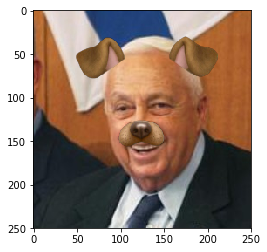

Probabily you own a "Parson russell terrier" or you should.


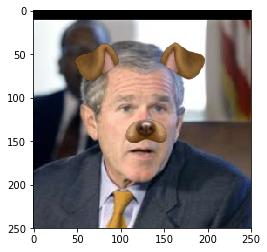

Probabily you own a "Petit basset griffon vendeen" or you should.


In [43]:
'''
Test dog breed prection on human faces. Using faces from lfw dataset.
'''
# test 1
outputResult(dog_classifier_obj.classify("lfw/Courtney_Love/Courtney_Love_0001.jpg"), addFaceMask=True)
# test 2
outputResult(dog_classifier_obj.classify("lfw/Ariel_Sharon/Ariel_Sharon_0074.jpg"), addFaceMask=True)
# test 3
outputResult(dog_classifier_obj.classify("lfw/George_W_Bush/George_W_Bush_0013.jpg"), addFaceMask=True)

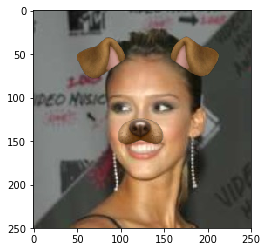

This looks like a human


This looks like a human


In [44]:
'''
Test faces with low dog breed match score (< 15%). Using faces from lfw dataset.
'''

# test with face mask > force add mask
outputResult(dog_classifier_obj.classify("lfw/Jessica_Alba/Jessica_Alba_0001.jpg"), addFaceMask=True)
# test without face mask
outputResult(dog_classifier_obj.classify("lfw/Nelson_Mandela/Nelson_Mandela_0003.jpg"))

___
**additionalImages/4.jpg**

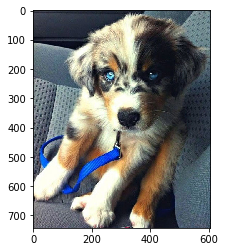

[[0.99295133, 0.0011967658, 0.00059933984], ['Australian_shepherd', 'Bearded_collie', 'Lowchen']]
Cute Dog. I guess it's a Australian shepherd?


___
**additionalImages/1.jpg**

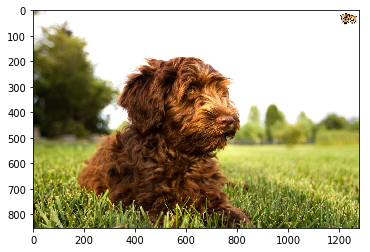

[[0.53055316, 0.45864427, 0.0020110493], ['Wirehaired_pointing_griffon', 'Portuguese_water_dog', 'Glen_of_imaal_terrier']]
Cute mutt. Looks like a crossbreed of Wirehaired pointing griffon / Portuguese water dog?


___
**additionalImages/2.jpg**

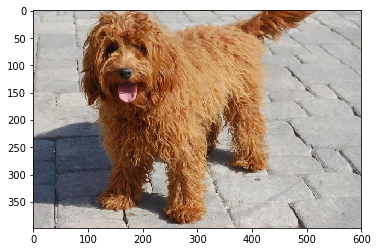

[[0.40719667, 0.31922808, 0.14949232], ['Wirehaired_pointing_griffon', 'Portuguese_water_dog', 'Otterhound']]
Cute mutt. Looks like a crossbreed of Wirehaired pointing griffon / Portuguese water dog?


___
**additionalImages/3.jpg**

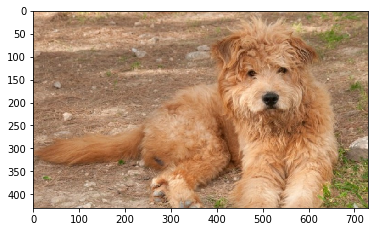

[[0.33226714, 0.2000158, 0.12677372], ['Otterhound', 'Lakeland_terrier', 'Glen_of_imaal_terrier']]
Cute mutt. Looks like a crossbreed of Otterhound / Lakeland terrier?


___
**additionalImages/benji2.jpg**

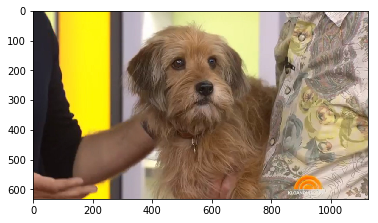

[[0.47218308, 0.15394354, 0.072925024], ['Norfolk_terrier', 'Otterhound', 'Dachshund']]
Cute mutt. Looks like a crossbreed of Norfolk terrier / Otterhound?


___
**additionalImages/dingo.jpg**

[[0.96650833, 0.0076306383, 0.0048569129], ['Canaan_dog', 'Basenji', 'Icelandic_sheepdog']]
Cute Dog. I guess it's a Canaan dog?


___
**additionalImages/5.jpg**

[[0.99774629, 0.00074725028, 0.00039945354], ['Portuguese_water_dog', 'Wirehaired_pointing_griffon', 'Poodle']]
Cute Dog. I guess it's a Portuguese water dog?


___
**additionalImages/bear.jpg**

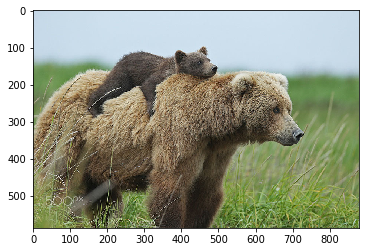

[[0.35026705, 0.16483249, 0.067128621], ['Chinese_shar-pei', 'American_staffordshire_terrier', 'Chesapeake_bay_retriever']]
Is it UFO, Alien or just Unknown object...


___
**additionalImages/6.jpg**

[[0.48881322, 0.1754432, 0.11876743], ['Miniature_schnauzer', 'Dachshund', 'German_wirehaired_pointer']]
Cute mutt. Looks like a crossbreed of Miniature schnauzer / Dachshund?


___
**additionalImages/7.jpg**

[[0.60251474, 0.37040389, 0.018061804], ['Border_collie', 'Belgian_sheepdog', 'Icelandic_sheepdog']]
Cute mutt. Looks like a crossbreed of Border collie / Belgian sheepdog?


___
**additionalImages/tiger.jpg**

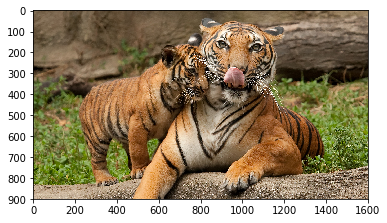

[[0.062127095, 0.055235509, 0.049915478], ['Dogue_de_bordeaux', 'Irish_red_and_white_setter', 'Greyhound']]
Is it UFO, Alien or just Unknown object...


___
**additionalImages/benji1.jpg**

[[0.41966492, 0.36242315, 0.064294025], ['Petit_basset_griffon_vendeen', 'Lowchen', 'Dachshund']]
Cute mutt. Looks like a crossbreed of Petit basset griffon vendeen / Lowchen?


___
**additionalImages/cat.jpg**

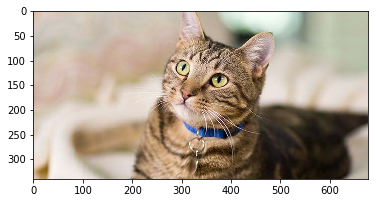

[[0.22917853, 0.12317696, 0.070488825], ['Bull_terrier', 'Neapolitan_mastiff', 'Dachshund']]
Is it UFO, Alien or just Unknown object...


In [45]:
'''
Test dog classifier on additionalImages folder
'''

import glob
from IPython.display import display, Markdown

additionalImages = np.array(glob.glob("additionalImages/*"))

for fn in additionalImages:
    display(Markdown('___\n**' + fn + '**'))
    outputResult(dog_classifier_obj.classify(fn), printTop3Predictions=True)

In [46]:
# clean up
del face_detector_MTCNN_obj
del dog_classifier_obj